<a href="https://colab.research.google.com/github/Sabry-Ahmed/CODE_Regression_lineaire_simple/blob/main/FraudActivities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.42.0.3-py2.py3-none-any.whl size=240945068 sha256=3c62d14454fdc37e3cd18d1a7c4a6299bc3bac517a1a4ed6eecf4d64f2052057
  Stored in directory: /root/.cache/pip/wheels/f9/7d/1d/e1258f0558603969a8393cb5b22a18e313337f01627a118302
Successfully built h2o


In [14]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.model_selection import train_test_split
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

In [6]:
data = pd.read_csv('/content/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
address2country = pd.read_csv('/content/IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [7]:
merged_data = pd.merge(data, address2country,
                       left_on='ip_address',
                       right_on='lower_bound_ip_address',
                       how='left')

In [8]:
merged_data['time_diff'] = (merged_data['purchase_time'] - merged_data['signup_time']).dt.total_seconds() / 3600  # Time difference in hours
merged_data['device_num'] = merged_data.groupby('device_id')['user_id'].transform('nunique')
merged_data['ip_num'] = merged_data.groupby('ip_address')['user_id'].transform('nunique')
merged_data['signup_day'] = merged_data['signup_time'].dt.dayofweek
merged_data['signup_week'] = merged_data['signup_time'].dt.isocalendar().week
merged_data['purchase_day'] = merged_data['purchase_time'].dt.dayofweek
merged_data['purchase_week'] = merged_data['purchase_time'].dt.isocalendar().week

In [10]:
merged_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,lower_bound_ip_address,upper_bound_ip_address,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,NaN,NaN,NaN,1251.856111,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,NaN,NaN,NaN,4.984444,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,NaN,NaN,NaN,0.000278,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,NaN,NaN,NaN,136.690278,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,NaN,NaN,NaN,1211.516944,1,1,1,30,2,37


In [12]:
final_data = merged_data.drop(columns=['signup_time', 'purchase_time', 'device_id', 'ip_address', 'user_id'])
cols_order = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
final_data = final_data[cols_order]
X = final_data.drop(columns=['class'])
y = final_data['class']


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test :", y_test.shape)

X_train : (105778, 13)
X_test : (45334, 13)
y_train : (105778,)
y_test : (45334,)


In [17]:
# Build random forest model
h2o.init()
train = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))
predictors = X_train.columns.tolist()
response = 'class'
drf = H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10)
drf.train(x=predictors, y=response, training_frame=train)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20" 2023-07-18; OpenJDK Runtime Environment (build 11.0.20+8-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20+8-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxkvq1pe6
  JVM stdout: /tmp/tmpxkvq1pe6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpxkvq1pe6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_unknownUser_2afsn5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1693486184132_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          2.42978e+06            20           20           20            2846          4671          3872.8

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.041418810766732025
RMSE: 0.20351611918158233
MAE: 0.08290804055156657
RMSLE: 0.14475127814753888
Mean Residual Deviance: 0.041418810766732025

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.04041527806407338
RMSE: 0.20103551443482162
MAE: 0.08299474939490029
RMSLE: 0.14217336576830159
Mean Residual Deviance: 0.04041527806407338

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.083005  0.00268547  0.0847119     0.0845741     0.0829472     0.0778297     0.0809045     0.0846865     0.0846981     0.0794247     0.0857404     0.0845332
mean_residual_deviance  0.040423  0.00239935  0.0421063     0.0405758     0.0404372     0.035323      0.0394361     0.0420055     0.0426963     0.0374734     0.0422516     0.0419247
mse                     0.040423  0.00239935  0.0421063     0.0405758     0.0404372     0.035323      0.0394361     0.0420055     0.0426963     0.0374734     0.0422516     0.0419247
r2                      0.524967  0.0238462   0.508545      0.522608      0.536046      0.56817       0.541626      0.515775      0.509542      0.544735      0.520586      0.482032
residual_deviance       0.040423  0.00239935  0.0421063     0.0405758     0.0404372     0.035323      0.0394361     0.0420055     0.0426963     0.0374734     0.0422516     0.0419247
rmse                    0.200972  0.0060672   0.205198      0.201434      0.20109       0.187944      0.198585      0.204952      0.206631      0.193581      0.205552      0.204755
rmsle                   0.142138  0.00389317  0.144695      0.142584      0.141949      0.133747      0.140394      0.144973      0.145795      0.137617      0.144978      0.144644

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------
    2023-08-31 12:55:18  5 min 10.972 sec  0                  nan              nan             nan
    2023-08-31 12:55:19  5 min 11.704 sec  1                  0.269393         0.0850339       0.0725728
    2023-08-31 12:55:20  5 min 12.400 sec  2                  0.264919         0.0844858       0.0701823
    2023-08-31 12:55:21  5 min 13.084 sec  3                  0.25688          0.0845606       0.0659873
    2023-08-31 12:55:21  5 min 13.716 sec  4                  0.248915         0.0837944       0.0619588
    2023-08-31 12:55:22  5 min 14.308 sec  5                  0.243902         0.0840693       0.0594883
    2023-08-31 12:55:22  5 min 14.933 sec  6                  0.239066         0.0843843       0.0571525
    2023-08-31 12:55:27  5 min 19.253 sec  15                 0.215684         0.0834962       0.0465194
    2023-08-31 12:55:31  5 min 23.780 sec  23                 0.2091           0.0830173       0.043723
    2023-08-31 12:55:35  5 min 27.992 sec  32                 0.206007         0.0829059       0.0424389
    

In [18]:
predictions_h2o = drf.predict(test)
predictions_df = predictions_h2o.as_data_frame()
threshold = 0.5
predictions_df['predict'] = (predictions_df['predict'] > threshold).astype(int)
classification_rep = classification_report(y_test, predictions_df['predict'])

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Text(0, 0.5, 'Feature')

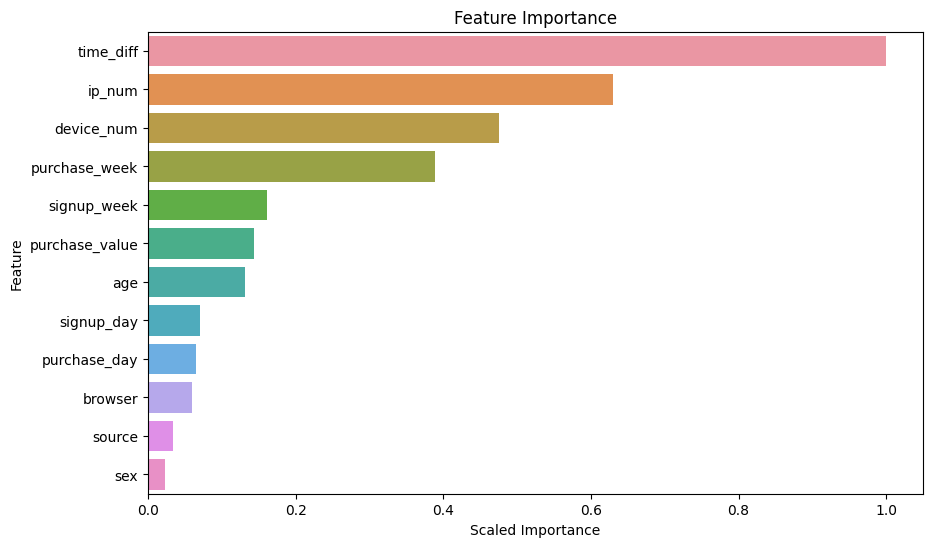

In [20]:
feature_importances = drf.varimp(use_pandas=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='scaled_importance', y='variable', data=feature_importances.sort_values(by='scaled_importance', ascending=False))
plt.title("Feature Importance")
plt.xlabel("Scaled Importance")
plt.ylabel("Feature")

In [22]:
predictions_h2o = drf.predict(test)
predictions_df = predictions_h2o.as_data_frame()
threshold = 0.5
predictions_df['predict'] = (predictions_df['predict'] > threshold).astype(int)
classification_rep = classification_report(y_test, predictions_df['predict'])
classification_rep

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


'              precision    recall  f1-score   support\n\n           0       0.96      1.00      0.98     41117\n           1       0.98      0.55      0.70      4217\n\n    accuracy                           0.96     45334\n   macro avg       0.97      0.77      0.84     45334\nweighted avg       0.96      0.96      0.95     45334\n'